In [21]:
import numpy as np
import matplotlib.pyplot as plt
#Convolutional layers should be NCHW (Number of outputs, Number of Channels, Height of Weights, Width of Weights)

def sigmoid(x):
    
    return 1/(1+np.exp(-1*x))

def sigmoid_grad(x):
    
    return np.multiply(x,(1.0-x))

class conv2d:
    
    def __init__(self,input_dim,output_channels,filter_dim,pad=False,stride=1,activation=True):
        
        self.weights = np.random.randn(output_channels, input_dim[0], filter_dim[0], filter_dim[1])
        #self.weights = np.ones((output_channels, input_dim[0], filter_dim[0], filter_dim[1]))
        self.bias = np.zeros((output_channels))
        self.inputs = np.zeros(input_dim)
        
        self.weight_gradient = np.zeros_like(self.weights)
        self.bias_gradient = np.zeros_like(self.bias) 
        
        if(pad==True):
            self.padding = (input_dim[1]*(stride-1) - stride + filter_dim[0])
            self.gradient = np.pad(self.inputs,((0,0),(self.padding//2,self.padding//2),(self.padding//2,self.padding//2)),'constant')
        else:
            self.padding = 0 
            self.gradient = np.zeros_like(self.inputs)
        

        out_dim = (input_dim[1] - filter_dim[0] + self.padding)//stride + 1
        self.outputs = np.zeros((output_channels, out_dim, out_dim))
        
        self.stride = stride
        
        if(activation==True):
            self.activate = True
        else:
            self.activate = False  
            
    def cnn(self, input):
        channels, input_h, input_w = input.shape
        outputs, channels, filter_h, filter_w = self.weights.shape
        
        if(self.padding!=0):
            new_input = np.pad(input,((0,0),(self.padding//2,self.padding//2),(self.padding//2,self.padding//2)),'constant') 
        
            out_w = (input_w - filter_w + self.padding)//self.stride + 1
            out_h = (input_h - filter_h + self.padding)//self.stride + 1
    
        else:
            new_input = input
            out_w = (input_w - filter_w)//self.stride + 1
            out_h = (input_h - filter_h)//self.stride + 1
        
        self.inputs = new_input
        
        for k in range(outputs):
            for i in range(out_h):
                for j in range(out_w):
                    self.outputs[k,i,j] = np.sum(np.multiply
                                                    (self.inputs[:,i*self.stride:i*self.stride+filter_h,
                                                                j*self.stride:j*self.stride+filter_w],
                                                    self.weights[k]))
                        
            self.outputs[k,:,:]+=self.bias[k]
    
    def forward(self,new_input):
        
        self.cnn(new_input)
        
        if(self.activate==True):
            self.outputs = sigmoid(self.outputs)
        
        return self.outputs
    
    
    def backprop(self,gradient,lr=0.01):
        
        channels, input_h, input_w = self.inputs.shape
        outputs, channels, filter_h, filter_w = self.weights.shape
        outputs, out_h, out_w = gradient.shape
        
        if(self.activate==True):
            gradient = np.multiply(gradient,sigmoid_grad(self.outputs))
        
        for k in range(outputs):
            self.bias_gradient[k] = np.sum(gradient[k,:,:]) 
        
        
        for k in range(outputs):
            for l in range(channels):
                for i in range(filter_h):
                    for j in range(filter_w):
                        self.weight_gradient[k,l,i,j] = np.sum(np.multiply
                                                                (self.inputs[l,i*self.stride:i*self.stride+out_h,
                                                                       j*self.stride:j*self.stride+out_w],
                                                             gradient[k,:,:]))
        
        new_weights = np.zeros_like(self.weights) 
        for i in range(filter_h):
            for j in range(filter_w):
                new_weights[:,:,i,j]=self.weights[:,:,filter_h-i-1,filter_w-j-1]


        padding = (self.inputs.shape[1]-1)*self.stride - gradient.shape[1] + new_weights.shape[2]
        if(padding!=0):
            padded_gradient = np.pad(gradient,((0,0),(padding//2,padding//2),
                                      (padding//2,padding//2)),'constant')
        else:
            padded_gradient = gradient.copy()
        for k in range(channels):
                for i in range(input_h):
                    for j in range(input_w):
                        self.gradient[k,i,j] = np.sum(np.multiply
                                                                (padded_gradient[:,i*self.stride:i*self.stride+filter_h,
                                                                       j*self.stride:j*self.stride+filter_w],
                                                             new_weights[:,k,:,:]))
                        
        self.weights -= lr*self.weight_gradient
        self.bias -= lr*self.bias_gradient
        
        if(self.padding!=0):
            return self.gradient[:,self.padding//2:-self.padding//2,self.padding//2:-self.padding//2]
        else:
            return self.gradient
        
        
class fc:
    
    def __init__(self,inputs,output,activation=True):
        
        self.weights = np.random.randn(output,inputs)
        self.bias = np.zeros(output)
        self.inputs = np.zeros(inputs)
        self.outputs = np.zeros(output)
        self.activate = False
        
        if(activation==True):
            self.activate = True
    
    def forward(self,new_input):
        self.inputs = new_input
        self.outputs = np.add(np.matmul((self.weights),new_input),self.bias)
        
        if(self.activate==True):
            self.outputs = sigmoid(self.outputs)
        
        return self.outputs
    
    def backprop(self,gradient,lr=0.01):
        
        if(self.activate==True):
            gradient = np.multiply(gradient,sigmoid_grad(self.outputs))
        
        gradient_weights = np.matmul(gradient.reshape(gradient.shape[0],1),
                                     (self.inputs).reshape(1,(self.inputs).shape[0]))
        gradient_bias = gradient
        
        
        output_gradient = np.matmul((self.weights).T,gradient)
        self.weights -= lr*gradient_weights
        self.bias -= lr*gradient_bias
        
    
        return output_gradient

class max_pool:
    
    def __init__(self,inputs_dim,pool_param,stride):
        
        self.inputs_dim = inputs_dim 
        self.pool_height,self.pool_width = pool_param
        self.stride = stride
        self.input = None

    def forward(self,x):
    
        C, H, W = self.inputs_dim
    
        W_P = self.pool_width
        
        H_P = self.pool_height
    
        self.input = x
        
        stride = self.stride
        
        HH = 1 + (H - H_P)//stride
        WW = 1 + (W - W_P)//stride
    
        out = np.zeros((C, HH, WW))
    
        for depth in range(C):
            for r in range(0,H,stride):
                for c in range(0,W,stride):
                
                    out[depth,r//stride,c//stride] = np.max(x[depth,r:r+H_P,c:c+W_P])
    
        return out

    def backprop(self,dout):
    
        C, H, W = self.inputs_dim
    
        CC,HH,WW = dout.shape
        
        W_P = self.pool_width
        
        H_P = self.pool_height  
        
        stride = self.stride
        
        dx = None
        dx = np.zeros(self.inputs_dim)
    
        for depth in range(C):
            for r in range(HH):
                for c in range(WW):
                
                    x_pool = self.input[depth,r*stride:r*stride+H_P,c*stride:c*stride+W_P]
                
                    mask = (x_pool == np.max(x_pool))
                
                    dx[depth,r*stride:r*stride+H_P,c*stride:c*stride+W_P] = mask * dout[depth,r,c] 
    
        return dx

In [22]:
train_imgs = np.load('train_imgs.npy')
test_imgs = np.load('test_imgs.npy')

train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

train_imgs = train_imgs.reshape((train_imgs.shape[0],1,28,28))
train_imgs = np.pad(train_imgs,((0,0),(0,0),(2,2),(2,2)),'constant')

test_imgs = test_imgs.reshape((test_imgs.shape[0],1,28,28))
test_imgs = np.pad(test_imgs,((0,0),(0,0),(2,2),(2,2)),'constant')

5


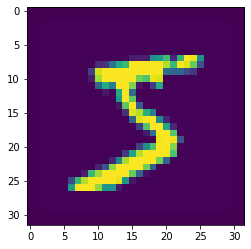

0


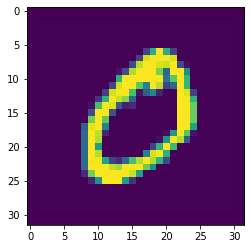

4


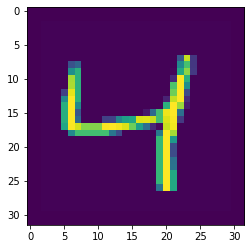

1


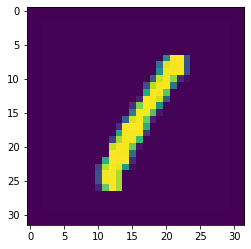

9


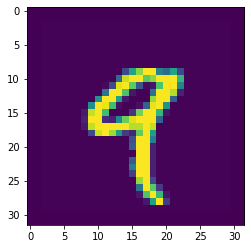

2


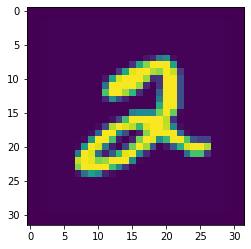

1


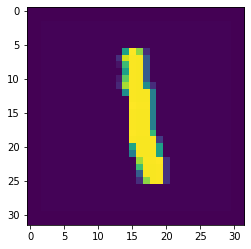

3


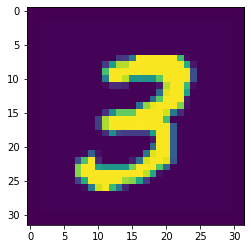

1


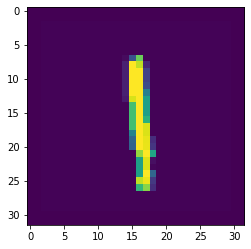

4


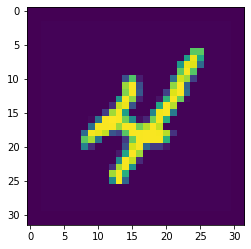

In [25]:
for i in range(10):
    plt.imshow(train_imgs[i,0])
    print(int(train_labels[i]))
    plt.show()

In [ ]:
conv1 = conv2d([1, 32, 32], 6, [5,5])
max1 = max_pool([6, 28, 28], [2,2], 2)
conv2 = conv2d([6, 14, 14], 16, [5,5])
max2 = max_pool([16, 10, 10], [2,2], 2)

#output is 16x5x5

fc1 = fc(16*5*5,120)
fc2 = fc(120,84)
fc3 = fc(84,10,False)

out = np.ones(10)*0.01

loss_epoch = []

def train(inputs):
    
    conv_op_1 = conv1.forward(inputs)
    max_op_1 = max1.forward(conv_op_1)
    conv_op_2 = conv2.forward(max_op_1)
    max_op_2 = max2.forward(conv_op_2)
    
    flatten_op = max_op_2.ravel()
    
    fc_op_1 = fc1.forward(flatten_op)
    fc_op_2 = fc2.forward(fc_op_1)
    fc_op_3 = fc3.forward(fc_op_2)
    
    return fc_op_3
    

def backprop(gradient):
    
    gradient = fc3.backprop(gradient)
    gradient = fc2.backprop(gradient)
    gradient = fc1.backprop(gradient)
    
    gradient = gradient.reshape((16,5,5))
    
    gradient = max2.backprop(gradient)
    gradient = conv2.backprop(gradient)
    gradient = max1.backprop(gradient)
    gradient = conv1.backprop(gradient)

for epoch in range(5):
    
    loss = 0
    
    for i in range(train_imgs.shape[0]):
        
        output = train(train_imgs[i])
        out[int(train_labels[i])] = 0.99
        
        if (i+1)%10 == 0 :
            print(np.mean((output-out[int(train_labels[i])])**2))
            
        loss += np.mean((output-out[int(train_labels[i])])**2)
        backprop(output-out)
        out[int(train_labels[i])] = 0.01
        
        
    loss_epoch.append(loss)
    
plt.plot(loss_epoch)
plt.show()

#train_imgs[1]
#out[int(train_labels[1])] = 0.99
#print(out)

#i = 20

#for epoch in range(11):
    
#    output = train(train_imgs[i])
#    print(np.argmax(output))
#    out[int(train_labels[i])] = 0.99
#    backprop(output-out)
#    out[int(train_labels[i])] = 0
    

0.8655052962993641
0.9185421395081287
0.653486716041207
0.9348619544051833
0.7561483286788436
0.8076153155902341
0.8838259072380593
0.792160238189513
0.769674544087823
0.7918177749244996
0.8220094826736398
0.7786393616784006
0.7600990244413002


In [15]:
train_labels[i]

array([4.])